In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

# 1. Random Classifier

In [3]:
df = pd.read_csv('Data.csv')


In [4]:
df.head()


,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
print(df.shape)

(4846, 2)


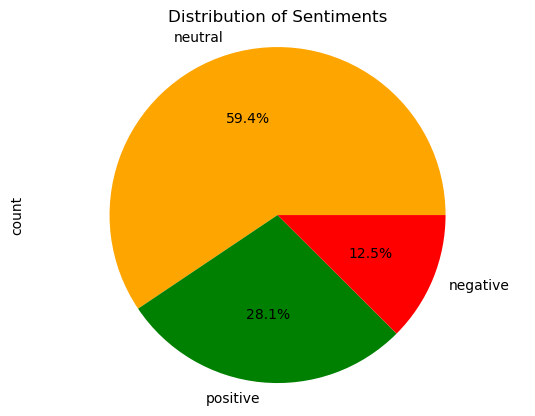

In [6]:
# Define colors for each sentiment category
colors = {'Negative': 'red', 'Neutral': 'orange', 'Positive': 'green'}

# Group by sentiment and count the occurrences
sentiment_counts = df['Sentiment'].value_counts()

# Plot a pie chart
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=[colors[s.capitalize()] for s in sentiment_counts.index])

# Add a title
plt.title('Distribution of Sentiments')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()


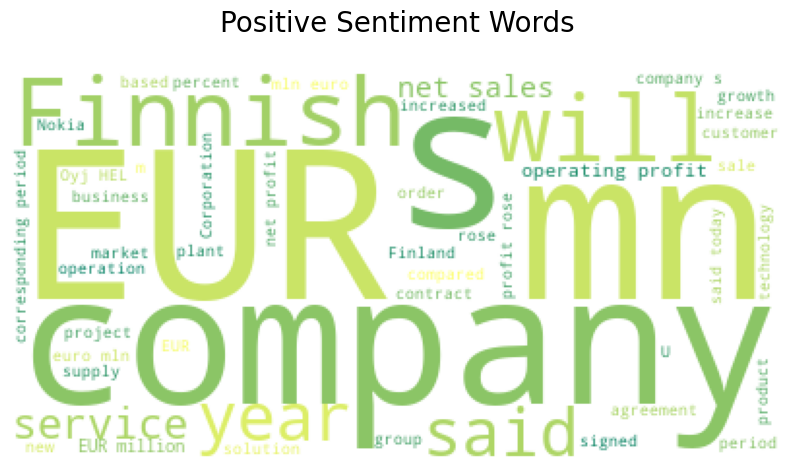

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcount_gen(df, category, colormap='viridis'):  # Add colormap parameter with default value 'viridis'
    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment == category]['Text']])
                          
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords=STOPWORDS,
                   colormap=colormap)  # Use the provided colormap

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words\n'.format(category.capitalize()), fontsize=20)  # Capitalize the category name
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment category with different themes
wordcount_gen(df, 'positive', colormap='summer') 
  


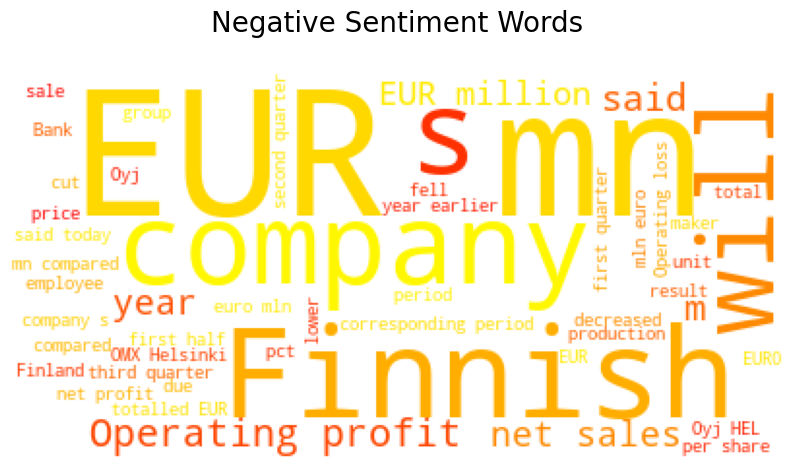

In [8]:
wordcount_gen(df, 'negative', colormap='autumn')  


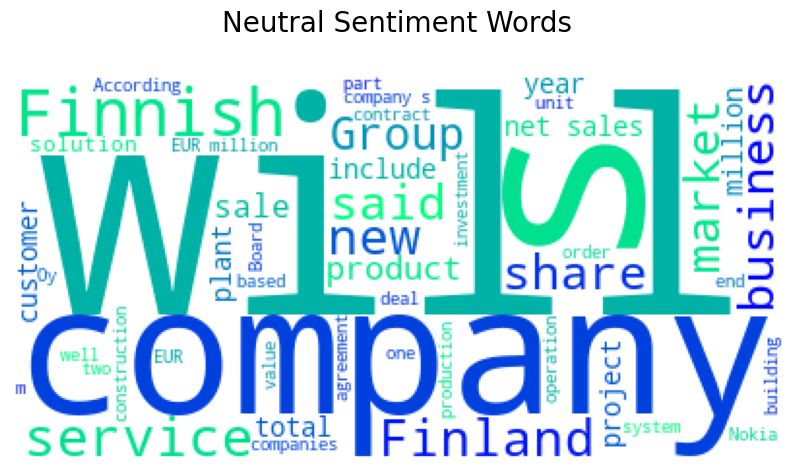

In [9]:
wordcount_gen(df, 'neutral', colormap='winter') 

In [10]:
example = df['Text'][30]
print(example)

The Brazilian unit of Finnish security solutions provider F-Secure signed up 1,500 new clients last year , online news source Reseller Web quoted the division 's commercial director , Vladimir Brand+_o , as saying .


In [11]:
# Tokenisation
tokens = nltk.word_tokenize(text = example, language='english')
print(tokens)

['The', 'Brazilian', 'unit', 'of', 'Finnish', 'security', 'solutions', 'provider', 'F-Secure', 'signed', 'up', '1,500', 'new', 'clients', 'last', 'year', ',', 'online', 'news', 'source', 'Reseller', 'Web', 'quoted', 'the', 'division', "'s", 'commercial', 'director', ',', 'Vladimir', 'Brand+_o', ',', 'as', 'saying', '.']


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Step 1: Data Preparation
X = df['Text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 3: Model Training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred = rf_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.7525773195876289
              precision    recall  f1-score   support

    negative       0.77      0.43      0.55       110
     neutral       0.74      0.96      0.83       571
    positive       0.80      0.47      0.59       289

    accuracy                           0.75       970
   macro avg       0.77      0.62      0.66       970
weighted avg       0.76      0.75      0.73       970

[[ 47  47  16]
 [  7 547  17]
 [  7 146 136]]


# Deployment

In [14]:
import joblib
import pandas as pd
from transformers import pipeline
import ipywidgets as widgets
from IPython.display import display

# Load the data
df = pd.read_csv('Data.csv')

# Load the BERT sentiment analysis pipeline
bert_classifier = pipeline("sentiment-analysis")

# Load the RandomForestClassifier model and vectorizer
loaded_model = joblib.load('random_forest_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Function to preprocess input text and make predictions using BERT
def predict_sentiment_bert(input_text):
    result = bert_classifier(input_text)[0]
    sentiment = result['label']
    return sentiment

# Function to preprocess input text and make predictions using RandomForestClassifier
def predict_sentiment_rf(input_text):
    input_vectorized = loaded_vectorizer.transform([input_text])
    prediction = loaded_model.predict(input_vectorized)[0]
    return prediction

# Define a function to handle button click event for prediction
def handle_prediction_button_click(b):
    input_text = input_text_widget.value
    bert_prediction = predict_sentiment_bert(input_text)
    rf_prediction = predict_sentiment_rf(input_text)
    output_text_widget.value = f"BERT Predicted sentiment: {bert_prediction}\nRandomForest Predicted sentiment: {rf_prediction}"

# Define a function to handle button click event for clearing input text
def handle_clear_button_click(b):
    input_text_widget.value = ''
    output_text_widget.value = ''

# Create an input widget
input_text_widget = widgets.Text(
    value='',
    placeholder='Enter text...',
    description='Text:',
    disabled=False
)

# Create a button widget for prediction
predict_button = widgets.Button(description='Predict')

# Create a button widget for clearing input text
clear_button = widgets.Button(description='Clear')

# Create an output widget
output_text_widget = widgets.Textarea(
    value='',
    placeholder='Predicted sentiment...',
    description='Output:',
    disabled=True
)

# Attach the button's click handler for prediction
predict_button.on_click(handle_prediction_button_click)

# Attach the button's click handler for clearing input text
clear_button.on_click(handle_clear_button_click)

# Display the widgets
display(input_text_widget)
display(widgets.HBox([predict_button, clear_button]))
display(output_text_widget)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text(value='', description='Text:', placeholder='Enter text...')

Textarea(value='', description='Output:', disabled=True, placeholder='Predicted sentiment...')

## 2. Simple Neural 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

In [16]:

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [19]:



# Load the data
df = pd.read_csv('Data.csv')

# Step 1: Data Preparation
X = df['Text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Define hyperparameters
input_dim = X_train_tensor.shape[1]
hidden_dim = 100
output_dim = len(label_encoder.classes_)
lr = 0.001
epochs = 10

# Initialize the model, loss function, and optimizer
model = SimpleNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []

# Training the model
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
     # Append the loss value to the list
    losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item()}")




Epoch [1/10], Train Loss: 1.123702049255371
Epoch [2/10], Train Loss: 1.119165301322937
Epoch [3/10], Train Loss: 1.11467707157135
Epoch [4/10], Train Loss: 1.110190749168396
Epoch [5/10], Train Loss: 1.1056338548660278
Epoch [6/10], Train Loss: 1.1009557247161865
Epoch [7/10], Train Loss: 1.0961027145385742
Epoch [8/10], Train Loss: 1.0910308361053467
Epoch [9/10], Train Loss: 1.085705280303955
Epoch [10/10], Train Loss: 1.0801072120666504


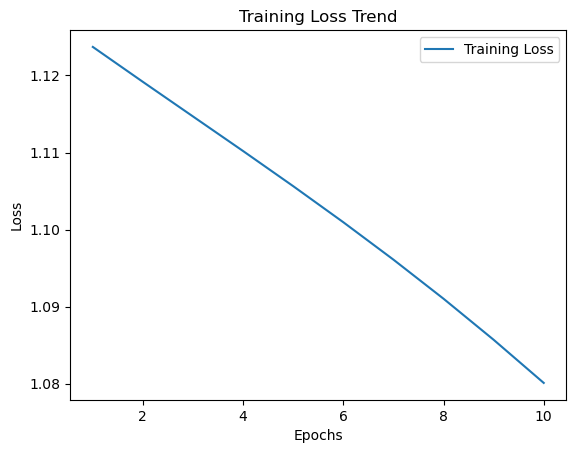

In [21]:
# Plot the training loss trend
plt.plot(range(1, epochs+1), losses, label='Training Loss')
plt.title('Training Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Step 4: Model Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor, predicted)
    print("Accuracy:", accuracy)
    print(classification_report(y_test_tensor, predicted))
    print(confusion_matrix(y_test_tensor, predicted))

Accuracy: 0.6164948453608248
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       110
           1       0.66      0.96      0.78       571
           2       0.00      0.00      0.00       289

    accuracy                           0.62       970
   macro avg       0.34      0.47      0.39       970
weighted avg       0.43      0.62      0.51       970

[[ 49  61   0]
 [ 22 549   0]
 [ 65 224   0]]


In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the data
df = pd.read_csv('Data.csv')

# Step 1: Data Preparation
X = df['Text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Define hyperparameters
input_dim = X_train_tensor.shape[1]
hidden_dim = 100
output_dim = len(label_encoder.classes_)
lr = 0.001
epochs = 10

# Define and print the model
model = SimpleNN(input_dim, hidden_dim, output_dim)
print(model)

# Print the summary of the model
summary(model, input_size=(input_dim,))



SimpleNN(
  (fc1): Linear(in_features=1000, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]         100,100
              ReLU-2                  [-1, 100]               0
            Linear-3                    [-1, 3]             303
        LogSoftmax-4                    [-1, 3]               0
Total params: 100,403
Trainable params: 100,403
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [46]:
# Define function to handle button click event for prediction
def handle_prediction_button_click(b):
    input_text = input_text_widget.value
    input_vectorized = tfidf_vectorizer.transform([input_text])
    input_tensor = torch.tensor(input_vectorized.toarray(), dtype=torch.float32)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_index = torch.max(output, 1)
        predicted_sentiment = label_encoder.classes_[predicted_index.item()]
        output_text_widget.value = f"Predicted sentiment: {predicted_sentiment}"

# Define function to handle button click event for clearing input text
def handle_clear_button_click(b):
    input_text_widget.value = ''
    output_text_widget.value = ''

# Create input box for entering text
input_text_widget = widgets.Text(
    value='',
    placeholder='Enter text...',
    description='Text:',
    disabled=False
)

# Create button for prediction
predict_button = widgets.Button(description='Predict')

# Create button for clearing input text
clear_button = widgets.Button(description='Clear')

# Create output widget
output_text_widget = widgets.Textarea(
    value='',
    placeholder='Predicted sentiment...',
    description='Output:',
    disabled=True
)

# Attach event handlers to buttons
predict_button.on_click(handle_prediction_button_click)
clear_button.on_click(handle_clear_button_click)

# Display widgets
display(input_text_widget)
display(widgets.HBox([predict_button, clear_button]))
display(output_text_widget)


Text(value='', description='Text:', placeholder='Enter text...')

Textarea(value='', description='Output:', disabled=True, placeholder='Predicted sentiment...')

In [50]:
import torch
import ipywidgets as widgets

# Define a sample model (replace this with your actual model)
class SampleModel(torch.nn.Module):
    def __init__(self):
        super(SampleModel, self).__init__()
        self.fc = torch.nn.Linear(1000, 3)  # Example: input size 1000, output size 3 for sentiment classes

    def forward(self, x):
        return self.fc(x)

# Define a sample TF-IDF vectorizer (replace this with your actual vectorizer)
class SampleTfidfVectorizer:
    def transform(self, texts):
        # Dummy implementation: return a matrix of zeros
        return torch.zeros(len(texts), 1000)

# Define a sample label encoder (replace this with your actual label encoder)
class SampleLabelEncoder:
    classes_ = ['Positive','Negative', 'Neutral']  # Example sentiment labels

# Create sample instances of model, TF-IDF vectorizer, and label encoder
model = SampleModel()
tfidf_vectorizer = SampleTfidfVectorizer()
label_encoder = SampleLabelEncoder()

# Define function to handle button click event for prediction
def handle_prediction_button_click(b):
    input_text = input_text_widget.value
    if input_text:
        input_vectorized = tfidf_vectorizer.transform([input_text])
        input_tensor = torch.tensor(input_vectorized, dtype=torch.float32)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_index = torch.max(output, 1)
            predicted_sentiment = label_encoder.classes_[predicted_index.item()]
            output_text_widget.value = f"Predicted sentiment: {predicted_sentiment}"
    else:
        output_text_widget.value = "Please enter text for prediction."

# Create input box for entering text
input_text_widget = widgets.Text(
    value='',
    placeholder='Enter text...',
    description='Text:',
    disabled=False
)

# Create button for prediction
predict_button = widgets.Button(description='Predict')

# Create output widget
output_text_widget = widgets.Textarea(
    value='',
    placeholder='Predicted sentiment...',
    description='Output:',
    disabled=True
)

# Attach event handler to button
predict_button.on_click(handle_prediction_button_click)

# Display widgets
display(input_text_widget)
display(predict_button)
display(output_text_widget)


Text(value='', description='Text:', placeholder='Enter text...')

Button(description='Predict', style=ButtonStyle())

Textarea(value='', description='Output:', disabled=True, placeholder='Predicted sentiment...')

## 3. LTSM MODEL Stock Prediction Model

In [ ]:
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import re
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import re
from ipywidgets import widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=pd.read_csv('Combined_News_DJIA.csv')

In [16]:
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [31]:


# Combine the top headlines into a single column
data['Combined'] = data.iloc[:, 2:].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Convert date to numerical representation
data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y%m%d').astype(int)

# Split the dataset into training and testing sets
X_text = data['Combined']
X_date = data['Date']
y = data['Label']
X_text_train, X_text_test, X_date_train, X_date_test, y_train, y_test = train_test_split(X_text, X_date, y, test_size=0.2, random_state=42)

# Tokenize the text data
def tokenizer(text):
    # Remove punctuation and split by whitespace
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return tokens

X_train_tokenized = [tokenizer(text) for text in X_text_train]
X_test_tokenized = [tokenizer(text) for text in X_text_test]

# Build vocabulary
word_to_idx = {}
idx_to_word = {}
for i, token in enumerate(set([token for sublist in X_train_tokenized for token in sublist])):
    word_to_idx[token] = i
    idx_to_word[i] = token

# Convert text to sequences of indices
X_train_indices = [[word_to_idx.get(token, 0) for token in text] for text in X_train_tokenized]
X_test_indices = [[word_to_idx.get(token, 0) for token in text] for text in X_test_tokenized]

# Pad sequences to ensure uniform length
max_length = max([len(seq) for seq in X_train_indices])
X_train_padded = [seq + [0]*(max_length-len(seq)) for seq in X_train_indices]
X_test_padded = [seq + [0]*(max_length-len(seq)) for seq in X_test_indices]

# Convert data to PyTorch tensors
X_train_text_tensor = torch.tensor(X_train_padded, dtype=torch.long)
X_test_text_tensor = torch.tensor(X_test_padded, dtype=torch.long)
X_train_date_tensor = torch.tensor(X_date_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_date_tensor = torch.tensor(X_date_test.values.reshape(-1, 1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [32]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_text = nn.Linear(hidden_dim, 50)
        self.fc_date = nn.Linear(1, 50)
        self.fc_combined = nn.Linear(100, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x_text, x_date):
        embedded_text = self.embedding(x_text)
        lstm_out_text, _ = self.lstm(embedded_text)
        lstm_out_text = lstm_out_text[:, -1, :]
        
        # Apply fully connected layers to text and date inputs separately
        out_text = self.fc_text(lstm_out_text)
        out_date = self.fc_date(x_date)
        
        # Concatenate the outputs of text and date layers
        combined = torch.cat((out_text, out_date), dim=1)
        
        # Apply fully connected layer to the combined output
        output = self.fc_combined(combined)
        output = self.sigmoid(output)
        return output

# Initialize the model, loss function, and optimizer
vocab_size = len(word_to_idx) + 1
embedding_dim = 100
hidden_dim = 50
output_dim = 1

In [33]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

# Define the training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for text, date, labels in iterator:
        optimizer.zero_grad()
        predictions = model(text, date).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Define the evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    predictions = []
    with torch.no_grad():
        for text, date, labels in iterator:
            output = model(text, date).squeeze(1)
            loss = criterion(output, labels)
            epoch_loss += loss.item()
            predictions += [int(pred > 0.5) for pred in output]
    return epoch_loss / len(iterator), predictions

# Train the model
BATCH_SIZE = 64
train_data = TensorDataset(X_train_text_tensor, X_train_date_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')




Epoch: 01, Train Loss: 52.651
Epoch: 02, Train Loss: 52.620
Epoch: 03, Train Loss: 52.702
Epoch: 04, Train Loss: 52.682
Epoch: 05, Train Loss: 52.672
Epoch: 06, Train Loss: 52.631
Epoch: 07, Train Loss: 52.702
Epoch: 08, Train Loss: 52.661
Epoch: 09, Train Loss: 52.702
Epoch: 10, Train Loss: 52.743


In [35]:
# Evaluate the model
test_data = TensorDataset(X_test_text_tensor, X_test_date_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
test_loss, predictions = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}')
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Test Loss: 57.844
Accuracy: 0.4296482412060301
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       171
           1       0.00      0.00      0.00       227

    accuracy                           0.43       398
   macro avg       0.21      0.50      0.30       398
weighted avg       0.18      0.43      0.26       398

[[171   0]
 [227   0]]


In [27]:
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')


# Deployment Stock Prediction

In [36]:

# Load the trained model
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()

# Create input widgets
headline_input = widgets.Textarea(placeholder='Enter the top headlines separated by commas')
date_input = widgets.Text(placeholder='Enter the date in YYYYMMDD format')
predict_button = widgets.Button(description='Predict')
clear_button = widgets.Button(description='Clear')
output_label = widgets.Label()

# Function to clear the input
def clear_input(_):
    headline_input.value = ''
    date_input.value = ''
    output_label.value = ''

# Function to predict the stock label
def predict_stock(_):
    headlines = headline_input.value
    date = date_input.value
    if headlines == '' or date == '':
        output_label.value = 'Please enter headlines and date.'
        return
    headlines = headlines.split(',')
    tokenized_headlines = [tokenizer(headline) for headline in headlines]
    indices = [[word_to_idx.get(token, 0) for token in headline] for headline in tokenized_headlines]
    padded_indices = [seq + [0]*(max_length-len(seq)) for seq in indices]
    text_tensor = torch.tensor(padded_indices, dtype=torch.long)
    date_tensor = torch.tensor([[int(date)]], dtype=torch.float32)
    with torch.no_grad():
        output = model(text_tensor, date_tensor)
    if output.item() >= 0.5:
        output_label.value = 'Predicted stock label: 1 (Up)'
    else:
        output_label.value = 'Predicted stock label: 0 (Down)'

# Attach event handlers to buttons
predict_button.on_click(predict_stock)
clear_button.on_click(clear_input)

# Display widgets
display(widgets.VBox([headline_input, date_input, widgets.HBox([predict_button, clear_button]), output_label]))


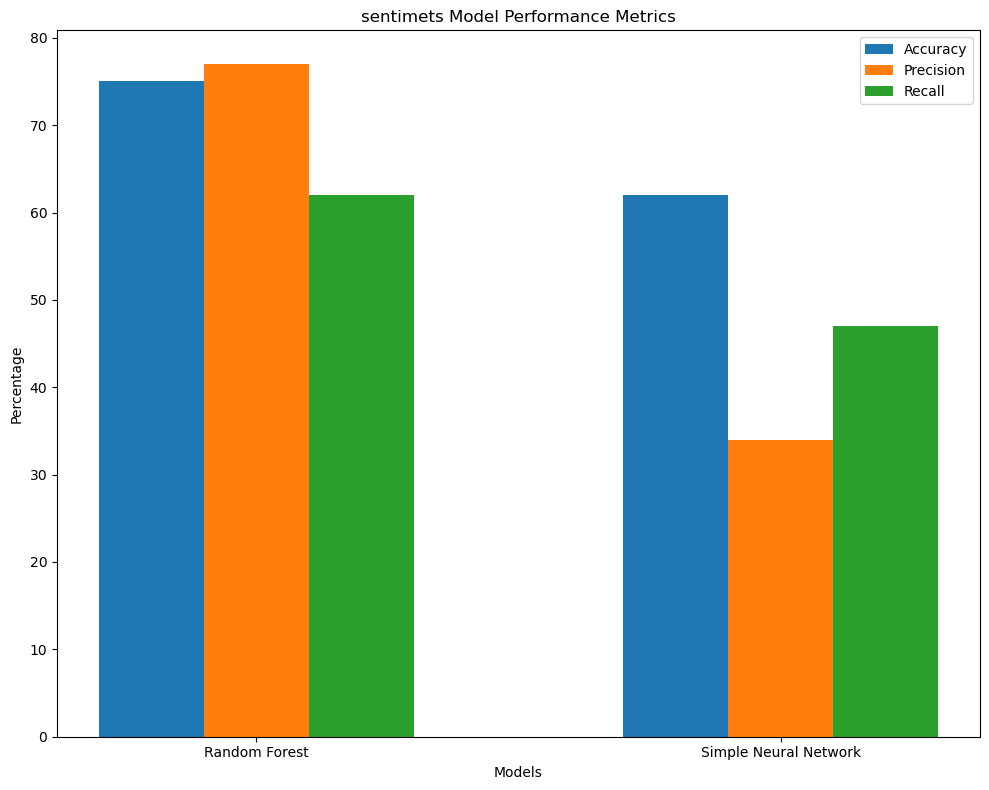

In [41]:
import matplotlib.pyplot as plt

# Data
models = ['Random Forest', 'Simple Neural Network']
accuracy = [75, 62]  # Accuracy in percentage
precision = [77, 34]  # Macro Avg Precision in percentage
recall = [62, 47]  # Macro Avg Recall in percentage

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bar_width = 0.2
index = range(len(models))

bar1 = ax.bar(index, accuracy, bar_width, label='Accuracy')
bar2 = ax.bar([i + bar_width for i in index], precision, bar_width, label='Precision')
bar3 = ax.bar([i + 2 * bar_width for i in index], recall, bar_width, label='Recall')

# Adding labels
ax.set_xlabel('Models')
ax.set_ylabel('Percentage')
ax.set_title('sentimets Model Performance Metrics')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.legend()

# Displaying the graph
plt.tight_layout()
plt.show()
